<a href="https://colab.research.google.com/github/saramony/Assignment-3/blob/master/MSDS_422_Assignment_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
# import packages
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate
from sklearn.naive_bayes import BernoulliNB, GaussianNB
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold, train_test_split
import itertools
import matplotlib.pyplot as plt

#Defines the URL for Github
url= 'https://raw.githubusercontent.com/saramony/Assignment-3/master/train.csv'

# Dataset is now stored in a Pandas Dataframe
TrainSet = pd.read_csv(url)

#Defines the shape of the data
print("The dataset has", len(TrainSet), "rows and", TrainSet.shape[1], "columns")

The dataset has 891 rows and 12 columns


In [19]:
TrainSet.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [20]:
# Get info on our columns and data size
TrainSet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


The number of passengers was 891
The number of survivers was 342 and the number of fatalities was 549


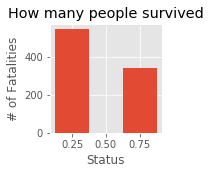

In [21]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns

print("The number of passengers was", len(TrainSet.Survived))
#Divides the passengers into survivors and fatalities

Survivors = TrainSet[TrainSet['Survived']==1] 
Fatalities = TrainSet[TrainSet['Survived']==0] 

# How many Survivers were there?
print("The number of survivers was", len(Survivors), "and the number of fatalities was", len(Fatalities))

TrainSet.Survived.hist(bins=2, rwidth=.5, figsize=(2,2))
plt.title('How many people survived')
plt.xlabel('Status')
plt.ylabel('# of Fatalities')
plt.show()

The minimum survivor age was 0.42 while themax age was 80.0


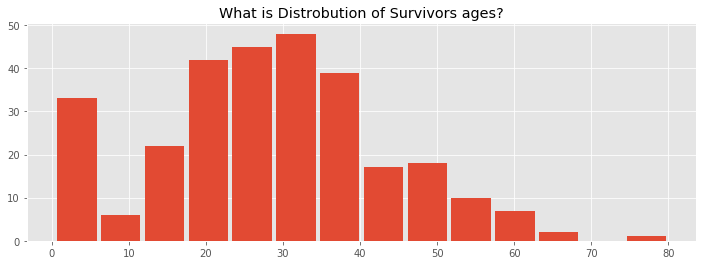

In [22]:
#What is the distrobution of age of each surviver

print("The minimum survivor age was",  Survivors.Age.min(), "while themax age was", Survivors.Age.max())
      
Survivors.Age.hist(bins=14, rwidth=.9, figsize=(12,4))
plt.title('What is Distrobution of Survivors ages?')
plt.show()

The minimum fatality age was 1.0 while the max age was 74.0


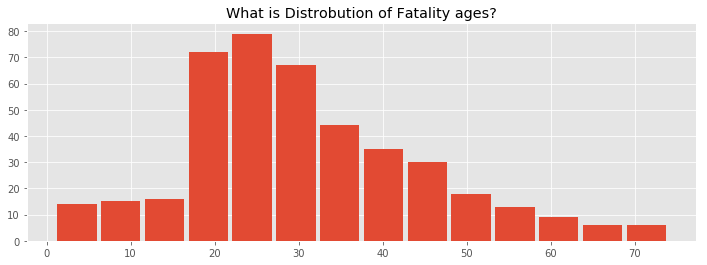

In [23]:
#What is the distrobution of age of each fatality

print("The minimum fatality age was",  Fatalities.Age.min(), "while the max age was", Fatalities.Age.max())
      
Fatalities.Age.hist(bins=14, rwidth=.9, figsize=(12,4))
plt.title('What is Distrobution of Fatality ages?')
plt.show()

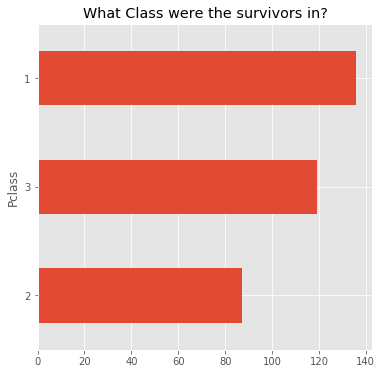

In [24]:
# What were the classes of each Survivor?
Survivors.groupby('Pclass').PassengerId.count().\
    sort_values().\
    plot(kind='barh', figsize=(6,6))
plt.title('What Class were the survivors in?')
plt.show()

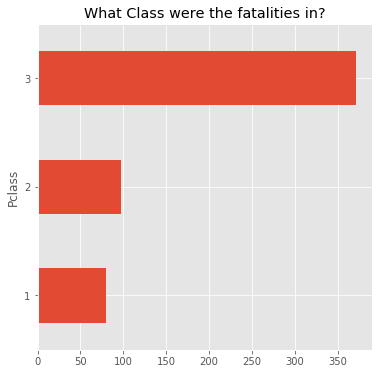

In [25]:
# What were the classes of each Fatality?
Fatalities.groupby('Pclass').PassengerId.count().\
    sort_values().\
    plot(kind='barh', figsize=(6,6))
plt.title('What Class were the fatalities in?')
plt.show()

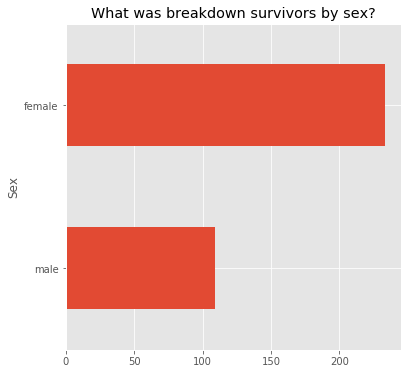

In [27]:
# What were the sexes of each Survivor?
Survivors.groupby('Sex').PassengerId.count().\
    sort_values().\
    plot(kind='barh', figsize=(6,6))
plt.title('What was breakdown survivors by sex?')
plt.show()

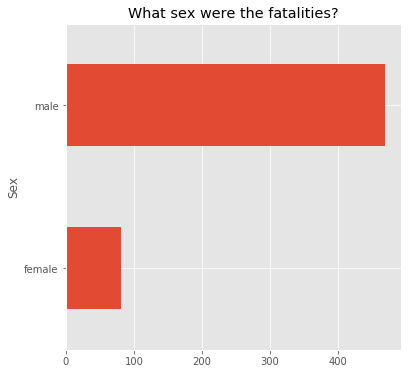

In [28]:
# What were the sexes of each Fatality?
Fatalities.groupby('Sex').PassengerId.count().\
    sort_values().\
    plot(kind='barh', figsize=(6,6))
plt.title('What sex were the fatalities?')
plt.show()

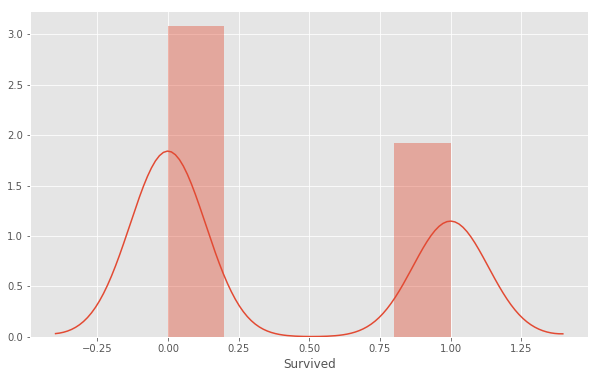

In [11]:
# Let's start with our dependent variable, Survival
plt.figure(figsize=(10,6))
sns.distplot(TrainSet.Survived)
plt.show()

In [0]:
def get_feature_groups():
    """ Returns a list of numerical and categorical features,
    excluding Survival. """
    # Numerical Features
    num_features = TrainSet.select_dtypes(include=['int64','float64']).columns
    num_features = num_features.drop(['Survived']) # drop Survived

    # Categorical Features
    cat_features = TrainSet.select_dtypes(include=['object']).columns
    return list(num_features), list(cat_features)

num_features, cat_features = get_feature_groups()

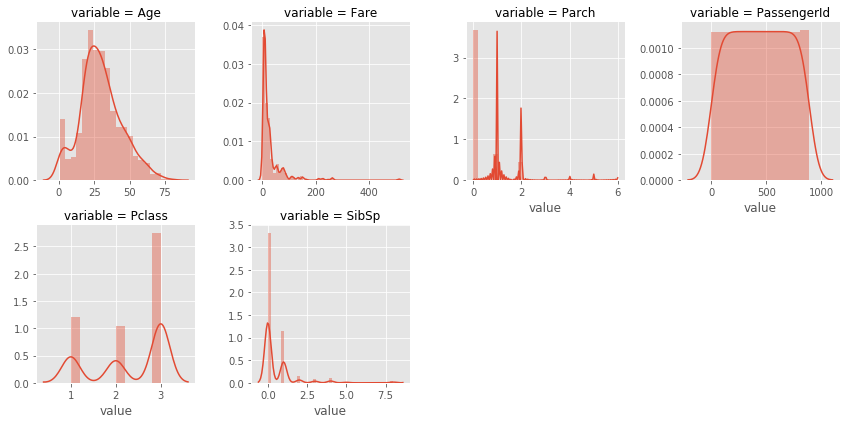

In [13]:

# Grid of distribution plots of all numerical features
f = pd.melt(TrainSet, value_vars=sorted(num_features))
g = sns.FacetGrid(f, col='variable', col_wrap=4, sharex=False, sharey=False)
g = g.map(sns.distplot, 'value')

In [3]:
#Prints the keys
list(TrainSet.keys())

['PassengerId',
 'Survived',
 'Pclass',
 'Name',
 'Sex',
 'Age',
 'SibSp',
 'Parch',
 'Ticket',
 'Fare',
 'Cabin',
 'Embarked']

In [0]:
# mapping function to convert sex male/female  to integer 0/1
convert_to_binary_sex = {'male' : 0, 'female' : 1}

Sex = TrainSet['Sex'].map(convert_to_binary_sex)
Sex.head()

#mapping function to convert 3rd class (if not 3rd class is 1)
convert_to_binary_class = {3 : 0, 2 : 1, 1 : 1}
Class = TrainSet['Pclass'].map(convert_to_binary_class)
Class.head()


#mapping function to convert Age (if under 20 - 1)
Age = (TrainSet['Age'] > 20).astype(int)

In [5]:
# gather three explanatory variables and response
model_data = np.array([
  np.array(Sex), 
  np.array(Class), 
  np.array(Age), 
  np.array(TrainSet.Survived)
]).transpose()

print('--Observations, Variables--\n', model_data.shape)

--Observations, Variables--
 (891, 4)


In [6]:

### LOGISTIC REGRESSION ###
print('\n\n### LOGISTIC REGRESSION ###\n')
X = model_data[:, 0:3]
y = model_data[:, 3]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

log_reg = LogisticRegression() 
log_reg.fit(X_train, y_train)
y_prob = log_reg.predict_proba(X_test)
print('\nProbabilities:\n', y_prob)



### LOGISTIC REGRESSION ###


Probabilities:
 [[0.86687682 0.13312318]
 [0.86687682 0.13312318]
 [0.86687682 0.13312318]
 [0.12562785 0.87437215]
 [0.43516815 0.56483185]
 [0.61780978 0.38219022]
 [0.16054813 0.83945187]
 [0.16054813 0.83945187]
 [0.68271756 0.31728244]
 [0.36660198 0.63339802]
 [0.89656698 0.10343302]
 [0.16054813 0.83945187]
 [0.86687682 0.13312318]
 [0.12562785 0.87437215]
 [0.16054813 0.83945187]
 [0.36660198 0.63339802]
 [0.89656698 0.10343302]
 [0.61780978 0.38219022]
 [0.89656698 0.10343302]
 [0.86687682 0.13312318]
 [0.61780978 0.38219022]
 [0.16054813 0.83945187]
 [0.86687682 0.13312318]
 [0.61780978 0.38219022]
 [0.43516815 0.56483185]
 [0.16054813 0.83945187]
 [0.89656698 0.10343302]
 [0.43516815 0.56483185]
 [0.16054813 0.83945187]
 [0.36660198 0.63339802]
 [0.89656698 0.10343302]
 [0.16054813 0.83945187]
 [0.89656698 0.10343302]
 [0.61780978 0.38219022]
 [0.89656698 0.10343302]
 [0.68271756 0.31728244]
 [0.89656698 0.10343302]
 [0.68271756 0.31728244]
 [

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [7]:
#Gives a scorecard of model
import sklearn.metrics as metrics

yhat = log_reg.predict(X_test)
print('\nNumber of yes predictions:', yhat.sum())
print('\nAccuracy of predictions:', metrics.accuracy_score(y_test, yhat))
print('\nConfusion Matrix:\n', metrics.confusion_matrix(y_test, yhat))
print('\nClassification Report:\n', metrics.classification_report(y_test, yhat))
print('\nAUROC:', roc_auc_score(y_test, y_prob[:, 1]))


Number of yes predictions: 83

Accuracy of predictions: 0.7802690582959642

Confusion Matrix:
 [[115  24]
 [ 25  59]]

Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.83      0.82       139
           1       0.71      0.70      0.71        84

    accuracy                           0.78       223
   macro avg       0.77      0.76      0.77       223
weighted avg       0.78      0.78      0.78       223


AUROC: 0.8443388146625557


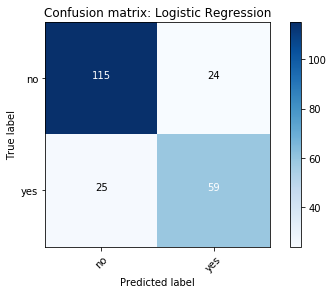

In [8]:
#Defines and prints a confusion matrix listed above
def plot_confusion_matrix(cm, classes, model,
                          title='Confusion matrix: ',
                          cmap=plt.cm.Blues):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title + model)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    # Plot non-normalized confusion matrix
np.set_printoptions(precision=2)
plt.figure()
plot_confusion_matrix(
  cm=metrics.confusion_matrix(y_test, yhat),
  classes=['no','yes'],
  model='Logistic Regression')
plt.show()

In [12]:
### NAIVE BAYES ###
print('\n\n### NAIVE BAYES ###\n')

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
prior = TrainSet.Survived.sum() / TrainSet.shape[0]

clf = BernoulliNB(
  alpha=1.0, 
  binarize=0.5, 
  class_prior=[1 - prior, prior], 
  fit_prior=False
)
clf.fit(X_train, y_train)

df = pd.DataFrame(X_test)
df.columns = ['Sex', 'Class', 'Age']
df['response'] = y_test

# add predicted probabilities to the training sample
df['prob_NO'] = clf.predict_proba(X_test)[:,0]
df['prob_YES'] = clf.predict_proba(X_test)[:,1]
df['prediction'] = clf.predict(X_test)
print(df.head(10))
print('\nNumber of yes predictions:', df.prediction.sum())
print('\nOverall training set accuracy:', clf.score(X_test, y_test))




### NAIVE BAYES ###

   Sex  Class  Age  response   prob_NO  prob_YES  prediction
0    0      0    0         0  0.892285  0.107715           0
1    0      0    0         0  0.892285  0.107715           0
2    0      0    0         0  0.892285  0.107715           0
3    1      1    0         1  0.146102  0.853898           1
4    1      0    1         1  0.390129  0.609871           1
5    0      1    0         1  0.682542  0.317458           0
6    1      1    1         1  0.142389  0.857611           1
7    1      1    1         1  0.142389  0.857611           1
8    0      1    1         1  0.675989  0.324011           0
9    1      0    0         1  0.397309  0.602691           1

Number of yes predictions: 83

Overall training set accuracy: 0.7802690582959642


In [14]:
### CROSS VALIDATION ###
print('\n\n### CROSS VALIDATION ###\n')
# Adapted from Scikit Learn documentation
names = ["Naive_Bayes", "Logistic_Regression"]
models = [
  BernoulliNB(
    alpha=1.0, 
    binarize=0.5, 
    class_prior = [0.5, 0.5], 
    fit_prior=False
  ), 
  LogisticRegression()
]



### CROSS VALIDATION ###




Fold index: 0 -----

Shape of input data for this fold:

X_train: (801, 3)
y_train: (801,)

X_test: (90, 3)
y_test: (90,)

Classifier evaluation for: Naive_Bayes

Scikit Learn method: BernoulliNB(alpha=1.0, binarize=0.5, class_prior=[0.5, 0.5], fit_prior=False)

Number of yes predictions: 28
Area under ROC curve: 0.8712557603686636


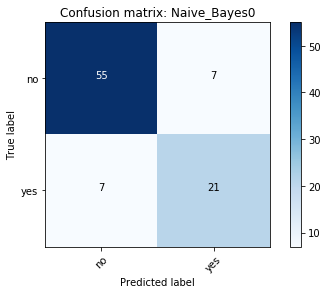


Classifier evaluation for: Logistic_Regression

Scikit Learn method: LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

Number of yes predictions: 28
Area under ROC curve: 0.8683755760368664


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


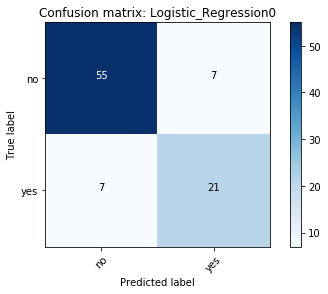


Fold index: 1 -----

Shape of input data for this fold:

X_train: (802, 3)
y_train: (802,)

X_test: (89, 3)
y_test: (89,)

Classifier evaluation for: Naive_Bayes

Scikit Learn method: BernoulliNB(alpha=1.0, binarize=0.5, class_prior=[0.5, 0.5], fit_prior=False)

Number of yes predictions: 36
Area under ROC curve: 0.7708565072302558


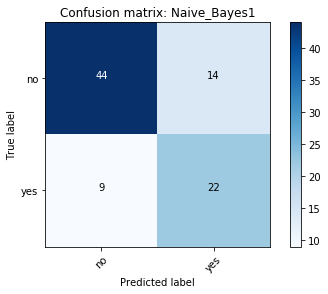


Classifier evaluation for: Logistic_Regression

Scikit Learn method: LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

Number of yes predictions: 36
Area under ROC curve: 0.8092324805339265


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


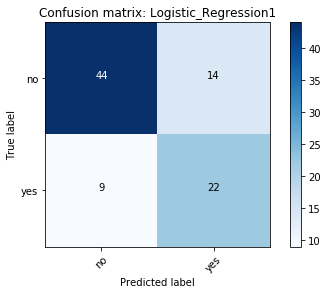


Fold index: 2 -----

Shape of input data for this fold:

X_train: (802, 3)
y_train: (802,)

X_test: (89, 3)
y_test: (89,)

Classifier evaluation for: Naive_Bayes

Scikit Learn method: BernoulliNB(alpha=1.0, binarize=0.5, class_prior=[0.5, 0.5], fit_prior=False)

Number of yes predictions: 25
Area under ROC curve: 0.7603174603174603


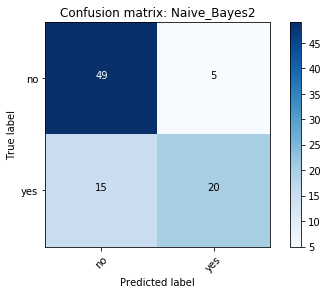


Classifier evaluation for: Logistic_Regression

Scikit Learn method: LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

Number of yes predictions: 25
Area under ROC curve: 0.7857142857142857


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


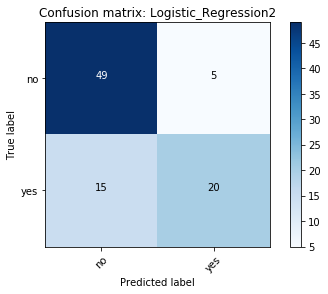


Fold index: 3 -----

Shape of input data for this fold:

X_train: (802, 3)
y_train: (802,)

X_test: (89, 3)
y_test: (89,)

Classifier evaluation for: Naive_Bayes

Scikit Learn method: BernoulliNB(alpha=1.0, binarize=0.5, class_prior=[0.5, 0.5], fit_prior=False)

Number of yes predictions: 30
Area under ROC curve: 0.7849025974025974


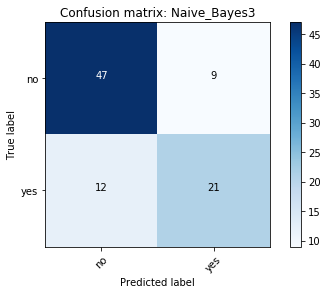


Classifier evaluation for: Logistic_Regression

Scikit Learn method: LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

Number of yes predictions: 30
Area under ROC curve: 0.8022186147186148


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


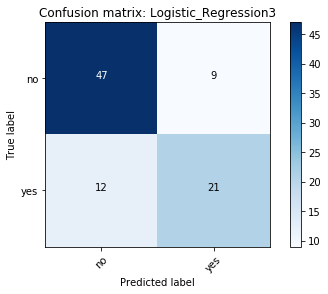


Fold index: 4 -----

Shape of input data for this fold:

X_train: (802, 3)
y_train: (802,)

X_test: (89, 3)
y_test: (89,)

Classifier evaluation for: Naive_Bayes

Scikit Learn method: BernoulliNB(alpha=1.0, binarize=0.5, class_prior=[0.5, 0.5], fit_prior=False)

Number of yes predictions: 32
Area under ROC curve: 0.8016774891774892


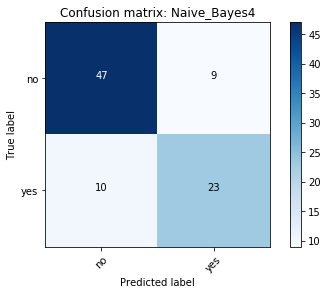


Classifier evaluation for: Logistic_Regression

Scikit Learn method: LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

Number of yes predictions: 32
Area under ROC curve: 0.7941017316017317


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


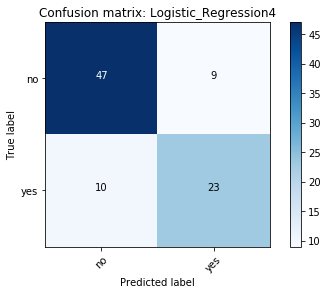


Fold index: 5 -----

Shape of input data for this fold:

X_train: (802, 3)
y_train: (802,)

X_test: (89, 3)
y_test: (89,)

Classifier evaluation for: Naive_Bayes

Scikit Learn method: BernoulliNB(alpha=1.0, binarize=0.5, class_prior=[0.5, 0.5], fit_prior=False)

Number of yes predictions: 41
Area under ROC curve: 0.9014690982776088


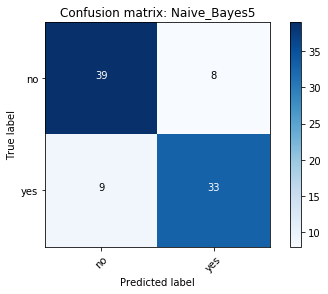


Classifier evaluation for: Logistic_Regression

Scikit Learn method: LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

Number of yes predictions: 41
Area under ROC curve: 0.9014690982776088


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


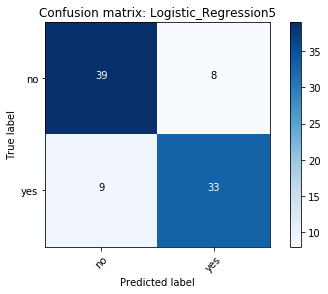


Fold index: 6 -----

Shape of input data for this fold:

X_train: (802, 3)
y_train: (802,)

X_test: (89, 3)
y_test: (89,)

Classifier evaluation for: Naive_Bayes

Scikit Learn method: BernoulliNB(alpha=1.0, binarize=0.5, class_prior=[0.5, 0.5], fit_prior=False)

Number of yes predictions: 28
Area under ROC curve: 0.7892316017316018


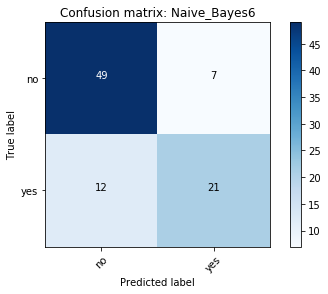


Classifier evaluation for: Logistic_Regression

Scikit Learn method: LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

Number of yes predictions: 28
Area under ROC curve: 0.8287337662337663


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


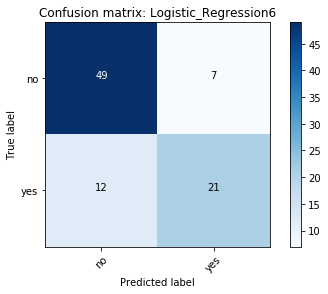


Fold index: 7 -----

Shape of input data for this fold:

X_train: (802, 3)
y_train: (802,)

X_test: (89, 3)
y_test: (89,)

Classifier evaluation for: Naive_Bayes

Scikit Learn method: BernoulliNB(alpha=1.0, binarize=0.5, class_prior=[0.5, 0.5], fit_prior=False)

Number of yes predictions: 26
Area under ROC curve: 0.7994252873563218


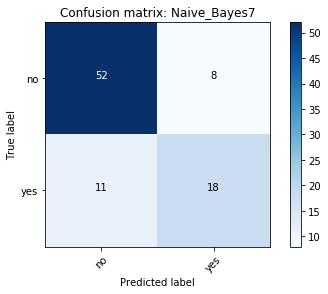


Classifier evaluation for: Logistic_Regression

Scikit Learn method: LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

Number of yes predictions: 26
Area under ROC curve: 0.8028735632183908


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


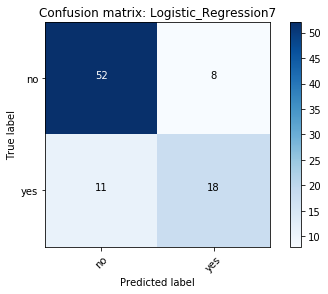


Fold index: 8 -----

Shape of input data for this fold:

X_train: (802, 3)
y_train: (802,)

X_test: (89, 3)
y_test: (89,)

Classifier evaluation for: Naive_Bayes

Scikit Learn method: BernoulliNB(alpha=1.0, binarize=0.5, class_prior=[0.5, 0.5], fit_prior=False)

Number of yes predictions: 33
Area under ROC curve: 0.8341759352881698


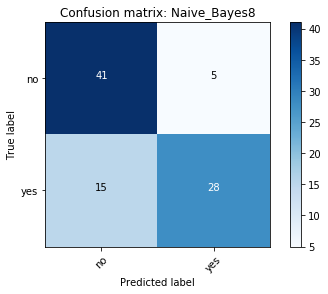


Classifier evaluation for: Logistic_Regression

Scikit Learn method: LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

Number of yes predictions: 33
Area under ROC curve: 0.8538928210313448


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


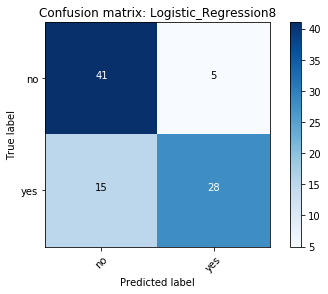


Fold index: 9 -----

Shape of input data for this fold:

X_train: (802, 3)
y_train: (802,)

X_test: (89, 3)
y_test: (89,)

Classifier evaluation for: Naive_Bayes

Scikit Learn method: BernoulliNB(alpha=1.0, binarize=0.5, class_prior=[0.5, 0.5], fit_prior=False)

Number of yes predictions: 35
Area under ROC curve: 0.8566137566137566


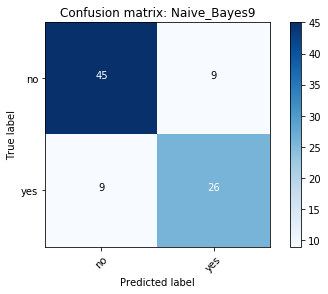


Classifier evaluation for: Logistic_Regression

Scikit Learn method: LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

Number of yes predictions: 35
Area under ROC curve: 0.8624338624338623


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


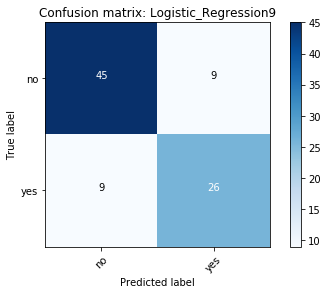


----------------------------------------------
Average results from 10-fold cross-validation

Method                 Area under ROC Curve
Naive_Bayes            0.816993
Logistic_Regression    0.830905
dtype: float64


In [16]:
# Set seed value for random number generators to obtain reproducible results
RANDOM_SEED = 85
# Shuffle the rows
np.random.seed(RANDOM_SEED)
np.random.shuffle(model_data)
num_folds = 10

# set up numpy array for storing results
results = np.zeros((num_folds, len(names)))

kf = KFold(
  n_splits=num_folds, 
  shuffle=False, 
  random_state=RANDOM_SEED
)

i = 0
for train_index, test_index in kf.split(model_data):
    print('\nFold index:', i, '-----')
  
    X_train = model_data[train_index, 0:X.shape[1]]
    y_train = model_data[train_index, X.shape[1]]
    
    X_test = model_data[test_index, 0:X.shape[1]]
    y_test = model_data[test_index, X.shape[1]]   
    
    print('\nShape of input data for this fold:\n')
    print('X_train:', X_train.shape)
    print('y_train:', y_train.shape)
    print('\nX_test:', X_test.shape)
    print('y_test:', y_test.shape)

    j = 0
    for name, model in zip(names, models):
        print('\nClassifier evaluation for:', name)
        print('\nScikit Learn method:', model)
        model.fit(X_train, y_train)
        
        # evaluate on the test set for this fold
        y_prob = model.predict_proba(X_test)
        print('\nNumber of yes predictions:', model.predict(X_test).sum())
        auroc = roc_auc_score(y_test, y_prob[:, 1]) 
        print('Area under ROC curve:', auroc)
        results[i, j] = auroc
        plt.figure()
        plot_confusion_matrix(
          cm=metrics.confusion_matrix(y_test, model.predict(X_test)), 
          classes=['no','yes'],
          model=name + str(i)
        )
        plt.show()
        j += 1
    i += 1

    
df = pd.DataFrame(results)
df.columns = names

print('\n----------------------------------------------')
print('Average results from ', 
      num_folds, 
      '-fold cross-validation\n',
      '\nMethod                 Area under ROC Curve', sep = '')     
print(df.mean())   